# Style Transfer
In this notebook I will implement the style transfer technique from ["Perceptual Losses for Real-Time Style Transfer and Super-Resolution" (Johnson et al., ECCV 2016)](http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

In [ ]:
%reload_ext autoreload
%autoreload 2

from scipy.misc import imread, imresize
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

tf.enable_eager_execution()

%matplotlib inline

import tensorflow_datasets as tfds

## Load COCO Datasets (train split only)

In [ ]:
coco_train = tfds.load(name="coco2014", split=tfds.Split.TRAIN)

# Build the transform network.
The architecture used in the paper [jcjohnson/fast-neural-style](https://github.com/jcjohnson/fast-neural-style/blob/master/doc/flags.md) is c9s1-32,d64,d128,R128,R128,R128,R128,R128,u64,u32,c9s1-3. All internal convolutional layers are followed by a ReLU and either batch normalization or instance normalization. <br>
-  cXsY-Z: A convolutional layer with a kernel size of X, a stride of Y, and Z filters.
-  dX: A downsampling convolutional layer with X filters, 3x3 kernels, and stride 2.
-  RX: A residual block with two convolutional layers and X filters per layer.
-  uX: An upsampling convolutional layer with X filters, 3x3 kernels, and stride 1/2.

In [ ]:
class ResnetIdentityBlock(tf.keras.Model):
  def __init__(self, kernel_size, filters, regularizer=None):
    super(ResnetIdentityBlock, self).__init__(name='')
    filters1, filters2 = filters

    self.conv2a = layers.Conv2D(filters1, kernel_size,
                                padding='same',
                                kernel_regularizer=regularizer,
                                bias_regularizer=regularizer)
    self.bn2a = layers.BatchNormalization(beta_regularizer=regularizer,
                                          gamma_regularizer=regularizer)
    self.relu2a = layers.ReLU()

    self.conv2b = layers.Conv2D(filters2, kernel_size,
                                padding='same',
                                kernel_regularizer=regularizer,
                                bias_regularizer=regularizer)
    self.bn2b = layers.BatchNormalization(beta_regularizer=regularizer,
                                          gamma_regularizer=regularizer)
    self.relu2b = layers.ReLU()

  def call(self, input_tensor, training=False):
    x = self.conv2a(input_tensor)
    x = self.bn2a(x, training=training)
    x = self.relu2a(x)
    
    x = self.conv2b(x)
    x = self.bn2b(x, training=training)
    
    x += input_tensor
    return self.relu2b(x)

In [ ]:
l2 = None
train_flag = True

IMG_SIZE = 256
input_tensor = layers.Input(shape=(None,None,3))

all_outputs = []
# Add convolutional layer with a kernel size of 9x9, a stride of 1, and 32 filters
conv1 = layers.Conv2D(filters=32, kernel_size=(9,9), strides=(1, 1),
                      padding='same',
                      kernel_regularizer=l2,
                      bias_regularizer=l2)(input_tensor)
conv1_bn = layers.BatchNormalization(beta_regularizer=l2,
                                     gamma_regularizer=l2)(conv1, training=train_flag)
conv1_relu = layers.ReLU()(conv1_bn)

all_outputs.append(conv1)
all_outputs.append(conv1_bn)
all_outputs.append(conv1_relu)

# Add downsampling convolutional layer with 64 filters, 3x3 kernels, and stride 2
conv2 = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2),
                      padding='same',
                      kernel_regularizer=l2,
                      bias_regularizer=l2)(conv1_relu)
conv2_bn = layers.BatchNormalization(beta_regularizer=l2,
                                     gamma_regularizer=l2)(conv2, training=train_flag)
conv2_relu = layers.ReLU()(conv2_bn)

all_outputs.append(conv2)
all_outputs.append(conv2_bn)
all_outputs.append(conv2_relu)

# Add downsampling convolutional layer with 128 filters, 3x3 kernels, and stride 2
conv3 = layers.Conv2D(filters=128, kernel_size=(3,3), strides=(2,2),
                      padding='same',
                      kernel_regularizer=l2,
                      bias_regularizer=l2)(conv2_relu)
conv3_bn = layers.BatchNormalization(beta_regularizer=l2,
                                     gamma_regularizer=l2)(conv3, training=train_flag)
conv3_relu = layers.ReLU()(conv3_bn)

all_outputs.append(conv3)
all_outputs.append(conv3_bn)
all_outputs.append(conv3_relu)

# Add residual block with two convolutional layers and 128 filters per layer
x = ResnetIdentityBlock(kernel_size=3, filters=[128,128])(conv3_relu, training=train_flag)
x = ResnetIdentityBlock(kernel_size=3, filters=[128,128])(x, training=train_flag)
x = ResnetIdentityBlock(kernel_size=3, filters=[128,128])(x, training=train_flag)
x = ResnetIdentityBlock(kernel_size=3, filters=[128,128])(x, training=train_flag)
x = ResnetIdentityBlock(kernel_size=3, filters=[128,128])(x, training=train_flag)

conv9 = layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2,2),
                               padding='same',
                               kernel_regularizer=l2,
                               bias_regularizer=l2)(x)
conv9_bn = layers.BatchNormalization(beta_regularizer=l2,
                                     gamma_regularizer=l2)(conv9, training=train_flag)
conv9_relu = layers.ReLU()(conv9_bn)

all_outputs.append(conv9)
all_outputs.append(conv9_bn)
all_outputs.append(conv9_relu)

conv10 = layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2),
                                padding='same',
                                kernel_regularizer=l2,
                                bias_regularizer=l2)(conv9_relu)
conv10_bn = layers.BatchNormalization(beta_regularizer=l2,
                                      gamma_regularizer=l2)(conv10, training=train_flag)
conv10_relu = layers.ReLU()(conv10_bn)

all_outputs.append(conv10)
all_outputs.append(conv10_bn)
all_outputs.append(conv10_relu)

conv11 = layers.Conv2D(filters=3, kernel_size=(9,9), strides=(1, 1),
                       padding='same',
                       kernel_regularizer=l2,
                       bias_regularizer=l2)(conv10_relu)
conv11_tanh = layers.Lambda(tf.keras.backend.tanh)(conv11)

all_outputs.append(conv11)
all_outputs.append(conv11_tanh)

## VGG16 Setup
Load the pretrained Keras VGG16 model.

In [ ]:
def freeze_model(model):
    '''
    model: an instance of Keras Application model
    '''
    for layer in model.layers:
        layer.trainable = False

In [ ]:
# style_layers = ['block1_conv2', 'block2_conv2',
#                 'block3_conv3', 'block4_conv3']
# thanks to https://github.com/OlavHN/fast-neural-style
style_layers = ['block1_conv1', 'block2_conv1',
                'block3_conv1', 'block4_conv1']
_style_layer_weights = np.ones(len(style_layers)) * 5.0

# content_layers = ['block3_conv3']
content_layers = ['block3_conv2']
_content_weights = np.ones(1)

_tv_weight = 1e-6

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import os

vgg_model = VGG16(weights='imagenet', include_top=False)
freeze_model(vgg_model)

content_feats = [vgg_model.get_layer(name).output for name in content_layers]
style_feats = [vgg_model.get_layer(name).output for name in style_layers]
vgg_model_x = tf.keras.Model(inputs=vgg_model.input,
                             outputs=(content_feats+style_feats))

# style_img_path = 'datasets/styles/starry_night_crop.png'
style_img_path = 'datasets/styles/the_scream.jpg'

img = image.load_img(style_img_path, target_size=(IMG_SIZE, IMG_SIZE))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

style_feats = vgg_model_x.predict(x)

## Computing Loss

We're going to compute the three components of our loss function now. The loss function is a weighted sum of three terms: content loss + style loss + total variation loss. You'll fill in the functions that compute these weighted terms below.

## Content loss
We can generate an image that reflects the content of one image and the style of another by incorporating both in our loss function. We want to penalize deviations from the content of the content image and deviations from the style of the style image. We can then use this hybrid loss function to perform gradient descent **not on the parameters** of the model, but instead **on the pixel values** of our original image.

Let's first write the content loss function. Content loss measures how much the feature map of the generated image differs from the feature map of the source image. We only care about the content representation of selected layers of the network (say, $\mathcal{L}$ is a set of K layers ). For a given layer $\ell \in \mathcal{L}$, it has feature maps $A^\ell \in \mathbb{R}^{1 \times H_\ell \times W_\ell \times C_\ell}$. $C_\ell$ is the number of filters/channels in layer $\ell$, $H_\ell$ and $W_\ell$ are the height and width. We will work with reshaped versions of these feature maps that combine all spatial positions into one dimension. Let $F^\ell \in \mathbb{R}^{N_\ell \times M_\ell}$ be the feature map for the current image and $P^\ell \in \mathbb{R}^{N_\ell \times M_\ell}$ be the feature map for the content source image where $M_\ell=H_\ell\times W_\ell$ is the number of elements in each feature map. Each row of $F^\ell$ or $P^\ell$ represents the vectorized activations of a particular filter, convolved over all positions of the image. Finally, let $w_c$ be the weight of the content loss term in the loss function.

Then the content loss is given by:

$L_c = w_c \times \sum_{\ell} \frac{1}{H_\ell \times W_\ell \times C_\ell} \sum_{i,j} (F_{ij}^{\ell} - P_{ij}^{\ell})^2$

In [ ]:
def content_loss(content_weights, content_current, content_original):
    """
    Compute the content loss for style transfer.
    
    Inputs:
    - content_weights: scalar constant we multiply the content_loss by.
    - content_current: features of the current image, a list of Tensors.
    - content_target: features of the content image, a list of Tensors, 
        with same shape as content_current.
    
    Returns:
    - scalar content loss
    """
    loss = 0.0
    for i in np.arange(len(content_weights)):
        loss += tf.reduce_mean((content_current[i] - content_original[i])**2) * content_weights[i]
    return loss

## Style loss
Now we can tackle the style loss. For a given layer $\ell$, the style loss is defined as follows:

First, compute the Gram matrix G which represents the correlations between the responses of each filter, where F is as above. The Gram matrix is an approximation to the covariance matrix -- we want the activation statistics of our generated image to match the activation statistics of our style image, and matching the (approximate) covariance is one way to do that. There are a variety of ways you could do this, but the Gram matrix is nice because it's easy to compute and in practice shows good results.

Given a feature map $F^\ell$ of shape $(1, M_\ell, C_\ell)$, the Gram matrix has shape $(C_\ell, C_\ell)$ and its elements are given by:

$$G_{ij}^\ell  = \sum_k F^{\ell}_{ik} F^{\ell}_{jk}$$

Assuming $G^\ell$ is the Gram matrix from the feature map of the current image, $A^\ell$ is the Gram Matrix from the feature map of the source style image, and $w_\ell$ a scalar weight term, then the style loss for the layer $\ell$ is simply the weighted Euclidean distance between the two Gram matrices:

$$L_s^\ell = w_\ell \times \frac{1}{C_\ell \times C_\ell} \sum_{i, j} \left(G^\ell_{ij} - A^\ell_{ij}\right)^2$$

In practice we usually compute the style loss at a set of layers $\mathcal{L}$ rather than just a single layer $\ell$; then the total style loss is the sum of style losses at each layer:

$$L_s = \sum_{\ell \in \mathcal{L}} L_s^\ell$$

Begin by implementing the Gram matrix computation below:

In [ ]:
def gram_matrix(features, normalize=True):
    """
    Compute the Gram matrix from features.
    
    Inputs:
    - features: Tensor of shape (N, H, W, C) giving features for
      N images.
    - normalize: optional, whether to normalize the Gram matrix
        If True, divide the Gram matrix by the number of neurons (H * W * C)
        H = tf.getshape(features)[1]
    Returns:
    - gram: Tensor of shape (N, C, C) giving the (optionally normalized)
      Gram matrices for the input images.
    """
    N, H, W, C = tf.shape(features)
    if normalize is True:
        features /= tf.sqrt(tf.cast(H*W*C, features.dtype))
    features = tf.reshape(features, (N,-1,C))
    features_T = tf.transpose(features, (0,2,1))
    grams = tf.matmul(features_T, features)
    return grams

Next, implement the style loss:

In [ ]:
import sys
def style_loss(feats, style_targets, style_weights):
    """
    Computes the style loss at a set of layers.
    
    Inputs:
    - feats: list of the features at every layer of the current image.
    - style_targets: List of the same length as feats, where style_targets[i] is
      a Tensor giving the Gram matrix the source style image computed at
      layer style_layers[i].
    - style_weights: List of the same length as style_targets, where style_weights[i]
      is a scalar giving the weight for the style loss at layer style_layers[i].
      
    Returns:
    - style_loss: A Tensor contataining the scalar style loss.
    """
    style_loss = tf.constant(0.0)
    for i in np.arange(len(feats)):
        layer_var = gram_matrix(feats[i])
        with tf.contrib.summary.always_record_summaries():
            tf.contrib.summary.histogram('sample_grams' + str(i), layer_var)
        loss_i = tf.reduce_mean((layer_var - style_targets[i])**2) * style_weights[i]
        style_loss = tf.add(style_loss, loss_i)
    return style_loss

## Total-variation regularization
It turns out that it's helpful to also encourage smoothness in the image. We can do this by adding another term to our loss that penalizes wiggles or "total variation" in the pixel values. 

You can compute the "total variation" as the sum of the squares of differences in the pixel values for all pairs of pixels that are next to each other (horizontally or vertically). Here we sum the total-variation regualarization for each of the 3 input channels (RGB), and weight the total summed loss by the total variation weight, $w_t$:

$L_{tv} = w_t \times \frac{1}{C \times (H-1) \times (W-1)} \times \sum_{c=1}^3\sum_{i=1}^{H-1} \sum_{j=1}^{W-1} \left( (x_{i,j+1, c} - x_{i,j,c})^2 + (x_{i+1, j,c} - x_{i,j,c})^2  \right)$

In the next cell, fill in the definition for the TV loss term. To receive full credit, your implementation should not have any loops.

In [ ]:
def tv_loss(img, tv_weight):
    """
    Compute total variation loss.
    
    Inputs:
    - img: Tensor of shape (N, H, W, 3) holding input images
    - tv_weight: Scalar giving the weight w_t to use for the TV loss.
    
    Returns:
    - loss: Tensor holding a scalar giving the total variation loss
      for img weighted by tv_weight.
    """
    shape = tf.shape(img)
    A = tf.slice(img, [0, 0, 0, 0], shape - [0, 1, 1, 0])
    B = tf.slice(img, [0, 1, 0, 0], shape - [0, 1, 1, 0])
    C = tf.slice(img, [0, 0, 1, 0], shape - [0, 1, 1, 0])
    loss = tv_weight * tf.reduce_sum((A - B)**2 + (A - C)**2) / tf.cast(shape[0], tf.float32)
    return loss

## Total Loss

In [ ]:
from utils.image_utils import preprocess_image

VGG_MEAN_BGR = np.array([103.939, 116.779, 123.68], dtype=np.float32)

def total_loss(model, orig_imgs, style_grams, content_weights, style_layer_weights, tv_weight):
    y_pred = model(orig_imgs)
    for i in np.arange(len(y_pred)):
        tf.check_numerics(y_pred[i], 'output' + str(i))
        
    y_pred_restored = (y_pred[-1] + 1) / 2 * 256
    y_pred_norm = y_pred_restored - VGG_MEAN_BGR[None,None,None]
    
    orig_feats = vgg_model_x(orig_imgs)
    y_pred_feats = vgg_model_x(y_pred_norm)
    
    IDX = len(content_weights)
    c_loss = content_loss(content_weights, y_pred_feats[:IDX], orig_feats[:IDX]) 
    # print weights to verify that vgg model is freezed
    s_loss = style_loss(y_pred_feats[IDX:], style_grams, style_layer_weights)
    
    t_loss = tv_loss(y_pred_norm, tv_weight)

    with tf.contrib.summary.record_summaries_every_n_global_steps(20):
#     with tf.contrib.summary.always_record_summaries():
        tf.contrib.summary.scalar('content_loss', c_loss)
        tf.contrib.summary.scalar('style_loss', s_loss)
        tf.contrib.summary.scalar('tv_loss', t_loss)
        for i in np.arange(len(y_pred)):
            tf.contrib.summary.histogram('output' + str(i), y_pred[i])
        for i in np.arange(len(y_pred_feats)):
            tf.contrib.summary.histogram('y_pred_feats' + str(i), y_pred_feats[i])
        for i in np.arange(len(orig_feats)):
            tf.contrib.summary.histogram('orig_feats' + str(i), orig_feats[i])
    return c_loss + s_loss + t_loss

## Style Grams

In [ ]:
test_img_path = 'datasets/examples/tubingen.jpg'
img = image.load_img(test_img_path, target_size=(IMG_SIZE, IMG_SIZE))
orig_img = image.img_to_array(img)
orig_img = np.expand_dims(orig_img, axis=0)
orig_img_norm = preprocess_input(orig_img)

IDX = len(content_layers)
style_grams = [gram_matrix(layer) for layer in style_feats[IDX:]]

## Gradient Function

In [ ]:
def grad(model, orig_imgs, style_grams, content_weights, style_layer_weights, tv_weight):
    with tf.GradientTape() as tape:
        loss_value = total_loss(model, orig_imgs, style_grams, content_weights, style_layer_weights, tv_weight)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

## Training Loop

In [ ]:
from utils.image_utils import preprocess_image, deprocess_image
import gc

# del model
# tf.keras.backend.clear_session()
# gc.collect()

def _pre_process(x):
    image_resized = tf.image.resize_images(x['image'], [IMG_SIZE, IMG_SIZE])
    image_centered = preprocess_image(image_resized[None])
    return image_centered[0]

# lr_space = np.power(10.0, np.arange(-4,2)) * 1.e-3
# weight_space = np.power(10.0, np.arange(-4,1))
# lr_space = [1e-7, 1e-7, 1e-6]
# weight_scale = [1e-2, 1e-3, 1e-4]

logdir = './tb/scream/scream_20_20_20_20'
writer = tf.contrib.summary.create_file_writer(logdir)
writer.set_as_default()

dataset = coco_train.repeat(2).map(_pre_process).batch(4).prefetch(tf.data.experimental.AUTOTUNE)

global_step = tf.train.get_or_create_global_step()
global_step.assign(0)

lr = 1e-4
content_weights = _content_weights
style_layer_weights = _style_layer_weights
style_layer_weights[0] = 20.0
style_layer_weights[1] = 20.0
style_layer_weights[2] = 20.0
style_layer_weights[3] = 20.0

tv_weight = _tv_weight * 1e2 * 0

print('lr: {}; content_weights: {}; style_weights: {}; tv_weight: {}'.
      format(lr, content_weights, style_layer_weights, tv_weight))

iterator = dataset.make_one_shot_iterator()

model = tf.keras.Model(inputs=input_tensor, outputs=all_outputs)
model.load_weights(logdir+'/training_checkpoint')
# model.save_weights('./my_checkpoint')

optimizer = tf.train.AdamOptimizer(learning_rate=lr)

with tf.contrib.summary.always_record_summaries():
    for k in np.arange(len(style_grams)):
        tf.contrib.summary.histogram('style_gram' + str(k), style_grams[k])

while True:
    try:
        batch_loss_avg = tf.contrib.eager.metrics.Mean()
        x = iterator.get_next()
        loss_value, grads = grad(model, x, style_grams, content_weights,
                                 style_layer_weights, tv_weight)
        for i in np.arange(len(grads)):
            tf.check_numerics(grads[i], 'check_numerics' + str(i))
#         for i in np.arange(len(grads)):
#             shape = np.shape(grads[i])
#             weight_scale = np.linalg.norm(tf.reshape(model.trainable_variables[i], [-1]))
#             update_scale = np.linalg.norm(tf.reshape(grads[i] * lr, [-1]))
#             update_ratio = update_scale / weight_scale
#             temp = []
#             if update_ratio > 0.1 or update_ratio < 1e-5 : 
#                 temp.append(i)
#                 temp.append(shape)
#                 temp.append(update_ratio)
#                 temp.append(np.mean(np.abs(update_scale)))
#                 temp.append(np.mean(np.abs(weight_scale)))
#             if len(temp) > 0 :
#                 print(*temp)
#                 temp = []
        optimizer.apply_gradients(zip(grads, model.trainable_variables),
                                  global_step)
        batch_loss_avg(loss_value)
        # Track progress
        if global_step.numpy() % 100 == 0:
            print("Step {:03d}: Loss: {:.3f}".format(global_step.numpy(), batch_loss_avg.result()))
        with tf.contrib.summary.record_summaries_every_n_global_steps(20):
#         with tf.contrib.summary.always_record_summaries():
            tf.contrib.summary.scalar('total_loss', batch_loss_avg.result())
            batch_loss_avg = tf.contrib.eager.metrics.Mean()
            for i in np.arange(len(grads)):
                tf.contrib.summary.histogram('grads'+str(i), grads[i])
                tf.contrib.summary.histogram('weights'+str(i), model.trainable_variables[i])
        with tf.contrib.summary.record_summaries_every_n_global_steps(200):
            sample_outputs = model.predict(orig_img_norm)
            sample_output_pp = ((sample_outputs[-1] + 1) / 2 * 256).astype(np.uint8)
            tf.contrib.summary.image('test', sample_output_pp[...,::-1], max_images=1, step=global_step.numpy())
        if global_step.numpy() % 1000 == 0:
            model.save_weights(logdir+'/training_checkpoint')
#         if global_step.numpy() % 3000 == 0:
#             break
    except tf.errors.OutOfRangeError:
        model.save_weights('./training_checkpoint')
        break
#         pred_img = model.predict(orig_img_norm)
#         pred_img_restore = ((pred_img[-1] + 1) / 2 * 256).astype(np.uint8)https://127.0.0.1:7000/notebooks/my-neural-style/StyleTransfer.ipynb#
#         plt.imshow(pred_img_restore[0][..., ::-1])
# del model
# gc.collect()

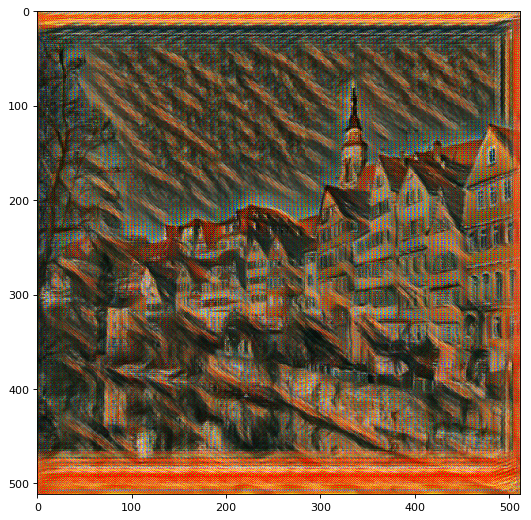

In [16]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

model = tf.keras.Model(inputs=input_tensor, outputs=all_outputs)
logdir = './tb/scream/scream_20_20_20_20'
model.load_weights(logdir+'/training_checkpoint')

test_img_path = 'datasets/examples/tubingen.jpg'
img = image.load_img(test_img_path, target_size=(512, 512))
orig_img = image.img_to_array(img)
orig_img_4d = np.expand_dims(orig_img, axis=0)
orig_img_norm = preprocess_input(orig_img_4d)
pred_img = model.predict(orig_img_norm)
pred_img_restore = ((pred_img[-1] + 1) / 2 * 256).astype(np.uint8)
plt.imshow(pred_img_restore[0][..., ::-1])

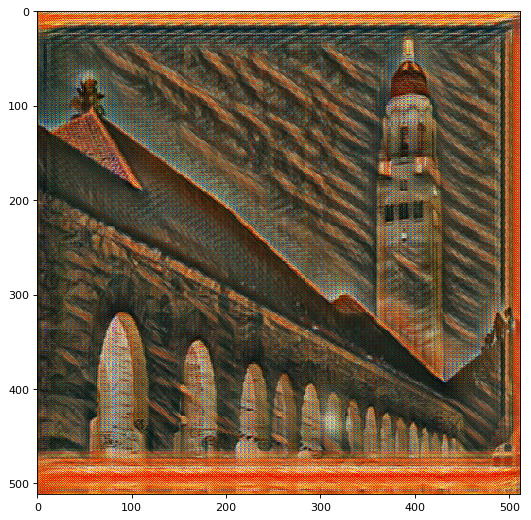

In [17]:
# model = tf.keras.Model(inputs=input_tensor, outputs=all_outputs)
# model.load_weights('./training_checkpoint')
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

test_img_path = 'datasets/examples/hoovertowernight.jpg'
img = image.load_img(test_img_path, target_size=(512, 512))
orig_img = image.img_to_array(img)
orig_img_4d = np.expand_dims(orig_img, axis=0)
orig_img_norm = preprocess_input(orig_img_4d)
pred_img = model.predict(orig_img_norm)
pred_img_restore = ((pred_img[-1] + 1) / 2 * 256).astype(np.uint8)
plt.imshow(pred_img_restore[0][..., ::-1])

## Style Transfer

Lets put it all together and make some beautiful images! The `style_transfer` function below combines all the losses you coded up above and optimizes for an image that minimizes the total loss.

## Generate some pretty pictures!

Try out `style_transfer` on the three different parameter sets below. Make sure to run all three cells. Feel free to add your own, but make sure to include the results of style transfer on the third parameter set (starry night) in your submitted notebook.

* The `content_image` is the filename of content image.
* The `style_image` is the filename of style image.
* The `image_size` is the size of smallest image dimension of the content image (used for content loss and generated image).
* The `style_size` is the size of smallest style image dimension.
* The `content_layer` specifies which layer to use for content loss.
* The `content_weight` gives weighting on content loss in the overall loss function. Increasing the value of this parameter will make the final image look more realistic (closer to the original content).
* `style_layers` specifies a list of which layers to use for style loss. 
* `style_weights` specifies a list of weights to use for each layer in style_layers (each of which will contribute a term to the overall style loss). We generally use higher weights for the earlier style layers because they describe more local/smaller scale features, which are more important to texture than features over larger receptive fields. In general, increasing these weights will make the resulting image look less like the original content and more distorted towards the appearance of the style image.
* `tv_weight` specifies the weighting of total variation regularization in the overall loss function. Increasing this value makes the resulting image look smoother and less jagged, at the cost of lower fidelity to style and content. 

Below the next three cells of code (in which you shouldn't change the hyperparameters), feel free to copy and paste the parameters to play around them and see how the resulting image changes. 